In [68]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder
import sklearn as sk
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


import sys  
sys.path.insert(0, '/root/Project-CS224N-ED-Disposition/')
from scripts import utils
import importlib
importlib.reload(utils)

index_col = 'Unnamed: 0'

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
df = pd.read_csv('/root/data/zero_shot_predictions/scores.csv').set_index(index_col)
df

,sequence,Edema,Opacities,Pericaridial effusion,Pneumonia,Pleural Effusion,Pneumothorax,Aspiration,Nephrolithiasis,Intraparenchymal hemorrhage,...,Cholecystitis,Intracranial hemorrhage,Stroke,Infection,Small bowel obstruction,Abdominal Aortic Aneurysm,Aortic dissection,Liver laceration,Colitis,Pancreatitis
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,1. Interval increase in perihilar opacities a...,0.929120,0.920819,0.737004,0.524612,0.185744,0.118200,0.045569,0.018194,0.014132,...,0.000431,0.000424,0.000250,0.000204,0.000184,0.000172,0.000117,0.000098,0.000074,0.000046
1,1. No acute intracranial abnormality. 2. Mil...,0.106327,0.090323,0.111382,0.000776,0.096998,0.001084,0.086613,0.028645,0.001540,...,0.018829,0.000796,0.005907,0.001479,0.000123,0.000192,0.000498,0.000157,0.011096,0.000875
2,1. Multiple loops of dilated small bowel with...,0.070339,0.741595,0.214792,0.007977,0.182043,0.072368,0.442881,0.017711,0.030738,...,0.044908,0.003074,0.008334,0.018739,0.967760,0.006287,0.003933,0.004344,0.007286,0.001242
3,1. Interval increased loculated moderate meta...,0.007522,0.441353,0.001170,0.004349,0.367867,0.008329,0.006146,0.001017,0.000746,...,0.000539,0.000267,0.000590,0.000482,0.000492,0.000297,0.000283,0.000482,0.000569,0.000209
4,1. Redemonstrated fracture of the femoral hea...,0.011500,0.378758,0.008745,0.001767,0.032812,0.004236,0.136899,0.022915,0.012002,...,0.004594,0.003910,0.008085,0.002214,0.002143,0.007413,0.001433,0.000586,0.003734,0.001374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146144,1. Acute superior endplate compression deform...,0.412637,0.565540,0.455190,0.018393,0.451436,0.060820,0.332372,0.102796,0.499176,...,0.230802,0.094018,0.164778,0.062306,0.011410,0.113403,0.036457,0.014308,0.135798,0.009234
146145,1. Diffuse anasarca and mesenteric edema. Pat...,0.909280,0.448288,0.229874,0.259759,0.905350,0.308534,0.230740,0.140058,0.238761,...,0.055338,0.068186,0.016210,0.020335,0.006509,0.030965,0.010458,0.020484,0.012868,0.002375
146146,1. No ultrasound evidence of deep venous thro...,0.012299,0.033661,0.014146,0.005479,0.021521,0.008577,0.062111,0.035728,0.032398,...,0.017090,0.013043,0.017339,0.003024,0.000778,0.061921,0.013719,0.005801,0.001874,0.000996


In [13]:
raw_train = pd.read_csv('/root/data/ed_train.csv').set_index(index_col)
raw_val = pd.read_csv('/root/data/ed_val.csv').set_index(index_col)
raw_test = pd.read_csv('/root/data/ed_test.csv').set_index(index_col)
print(len(raw_train), len(raw_val), len(raw_test))

102304 29230 14615


In [14]:
train_df = df.join(raw_train, how='right')
val_df = df.join(raw_val, how='right')
test_df = df.join(raw_test, how='right')
print(len(train_df), len(val_df), len(test_df))
assert len(train_df) == len(raw_train)
assert len(val_df) == len(raw_val)
assert len(test_df) == len(raw_test)

102304 29230 14615


In [15]:
X_train = train_df[utils.labels]
X_val = val_df[utils.labels]
X_test = test_df[utils.labels]

y_col = "ED_dispo"
y_train = train_df[[y_col]]
y_val = val_df[[y_col]]
y_test = test_df[[y_col]]

input_dim = len(X_train.columns)
output_dim = len(y_train[y_col].unique())
print(input_dim, output_dim)

31 4


In [16]:
label_enc = OneHotEncoder(handle_unknown='ignore')
label_enc.fit(y_train)
print(y_train[y_col].unique())
print(label_enc.categories_)
print(label_enc.transform(y_train).toarray())

['Admit to Inpatient' 'Discharge' 'Place in Observation-CDU'
 'Place in Observation']
[array(['Admit to Inpatient', 'Discharge', 'Place in Observation',
       'Place in Observation-CDU'], dtype=object)]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


In [17]:
class Data(Dataset):
  def __init__(self, X_train, y_train):
    # need to convert float64 to float32 else 
    # will get the following error
    # RuntimeError: expected scalar type Double but found Float
    self.X = torch.from_numpy(X_train.astype(np.float32).values).to(device)
    self.y = torch.from_numpy(label_enc.transform(y_train).toarray()).to(device)
    self.len = self.X.shape[0]
  
  def __getitem__(self, index):
    return self.X[index], self.y[index]

  def __len__(self):
    return self.len

train_data = Data(X_train, y_train)
val_data = Data(X_val, y_val)
test_data = Data(X_test, y_test)
print(train_data[0])

(tensor([2.2861e-01, 1.7704e-01, 9.8265e-01, 1.3679e-01, 1.1886e-02, 1.0064e-02,
        2.8919e-01, 5.4202e-02, 5.6665e-01, 1.6432e-01, 2.1832e-03, 6.6484e-03,
        7.1663e-03, 3.9533e-03, 2.6506e-02, 2.3122e-03, 2.7663e-03, 3.0448e-02,
        6.6401e-02, 9.0901e-03, 3.4748e-03, 2.0602e-03, 1.0667e-03, 3.9875e-03,
        4.4652e-04, 2.7340e-03, 3.7073e-02, 7.0074e-02, 5.1176e-01, 2.2719e-02,
        1.4835e-03], device='cuda:0'), tensor([1., 0., 0., 0.], device='cuda:0', dtype=torch.float64))


In [8]:
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
  def __init__(self, input_dim=31, output_dim=4, hidden_dim=64, dropout_prob=0.2, hidden_layers=1):
    super(Network, self).__init__()
    self.hidden_layers = hidden_layers
    self.dropout_in = nn.Dropout(dropout_prob)
    self.fc_in = nn.Linear(input_dim, hidden_dim)
    self.fc_out = nn.Linear(hidden_dim, output_dim)
    if hidden_layers > 1:
        self.dropout_mid = nn.Dropout(dropout_prob)
        self.fc_mid = nn.Linear(hidden_dim, hidden_dim)
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x):
    x = self.dropout_in(x)
    x = self.fc_in(x)
    x = F.gelu(x)
    
    if self.hidden_layers > 1:
        x = self.dropout_mid(x)
        x = self.fc_mid(x)
        x = F.gelu(x)

    x = self.fc_out(x)
    x = self.softmax(x)
    return x

file = open("/root/models/2/best.pickle", 'rb')
best = pickle.load(file)
best

{'best_acc': 0.6228190215531988,
 'best_model': Network(
   (dropout_in): Dropout(p=0, inplace=False)
   (fc_in): Linear(in_features=31, out_features=256, bias=True)
   (fc_out): Linear(in_features=256, out_features=4, bias=True)
   (dropout_mid): Dropout(p=0, inplace=False)
   (fc_mid): Linear(in_features=256, out_features=256, bias=True)
   (softmax): Softmax(dim=-1)
 ),
 'best_params': {'dropout_prob': 0,
  'epochs': 500,
  'hidden_dim': 256,
  'hidden_layers': 2,
  'lr': 0.01}}

In [6]:
%%sh
cat /root/models/2/logs.txt

0/288 params epochs=1 lr=0.01 hidden_dim=16 dropout_prob=0 hidden_layers=1 loss=1.20727 acc=0.47889 f1=0.47889
1/288 params epochs=1 lr=0.001 hidden_dim=16 dropout_prob=0 hidden_layers=1 loss=1.35485 acc=0.48905 f1=0.48905
2/288 params epochs=1 lr=0.0001 hidden_dim=16 dropout_prob=0 hidden_layers=1 loss=1.38351 acc=0.09069 f1=0.09069
3/288 params epochs=1 lr=1e-05 hidden_dim=16 dropout_prob=0 hidden_layers=1 loss=1.34323 acc=0.49138 f1=0.49138
4/288 params epochs=1 lr=0.01 hidden_dim=16 dropout_prob=0 hidden_layers=2 loss=1.17898 acc=0.57048 f1=0.57048
5/288 params epochs=1 lr=0.001 hidden_dim=16 dropout_prob=0 hidden_layers=2 loss=1.38342 acc=0.05830 f1=0.05830
6/288 params epochs=1 lr=0.0001 hidden_dim=16 dropout_prob=0 hidden_layers=2 loss=1.41039 acc=0.00619 f1=0.00619
7/288 params epochs=1 lr=1e-05 hidden_dim=16 dropout_prob=0 hidden_layers=2 loss=1.38788 acc=0.48905 f1=0.48905
8/288 params epochs=1 lr=0.01 hidden_dim=64 dropout_prob=0 hidden_layers=1 loss=1.16060 acc=0.57472 f1=0

72/288 params epochs=500 lr=0.01 hidden_dim=16 dropout_prob=0 hidden_layers=1 loss=1.11855 acc=0.61406 f1=0.61406
73/288 params epochs=500 lr=0.001 hidden_dim=16 dropout_prob=0 hidden_layers=1 loss=1.12020 acc=0.61310 f1=0.61310
74/288 params epochs=500 lr=0.0001 hidden_dim=16 dropout_prob=0 hidden_layers=1 loss=1.13912 acc=0.59141 f1=0.59141
75/288 params epochs=500 lr=1e-05 hidden_dim=16 dropout_prob=0 hidden_layers=1 loss=1.25858 acc=0.45217 f1=0.45217
76/288 params epochs=500 lr=0.01 hidden_dim=16 dropout_prob=0 hidden_layers=2 loss=1.11659 acc=0.61717 f1=0.61717
77/288 params epochs=500 lr=0.001 hidden_dim=16 dropout_prob=0 hidden_layers=2 loss=1.11948 acc=0.61238 f1=0.61238
78/288 params epochs=500 lr=0.0001 hidden_dim=16 dropout_prob=0 hidden_layers=2 loss=1.13457 acc=0.59603 f1=0.59603
79/288 params epochs=500 lr=1e-05 hidden_dim=16 dropout_prob=0 hidden_layers=2 loss=1.22467 acc=0.45217 f1=0.45217
80/288 params epochs=500 lr=0.01 hidden_dim=64 dropout_prob=0 hidden_layers=1 lo

143/288 params epochs=10 lr=1e-05 hidden_dim=256 dropout_prob=0.2 hidden_layers=2 loss=1.37255 acc=0.56158 f1=0.56158
144/288 params epochs=100 lr=0.01 hidden_dim=16 dropout_prob=0.2 hidden_layers=1 loss=1.13007 acc=0.59802 f1=0.59802
145/288 params epochs=100 lr=0.001 hidden_dim=16 dropout_prob=0.2 hidden_layers=1 loss=1.13946 acc=0.58601 f1=0.58601
146/288 params epochs=100 lr=0.0001 hidden_dim=16 dropout_prob=0.2 hidden_layers=1 loss=1.18488 acc=0.57650 f1=0.57650
147/288 params epochs=100 lr=1e-05 hidden_dim=16 dropout_prob=0.2 hidden_layers=1 loss=1.38568 acc=0.07116 f1=0.07116
148/288 params epochs=100 lr=0.01 hidden_dim=16 dropout_prob=0.2 hidden_layers=2 loss=1.12936 acc=0.59846 f1=0.59846
149/288 params epochs=100 lr=0.001 hidden_dim=16 dropout_prob=0.2 hidden_layers=2 loss=1.13401 acc=0.59371 f1=0.59371
150/288 params epochs=100 lr=0.0001 hidden_dim=16 dropout_prob=0.2 hidden_layers=2 loss=1.17141 acc=0.56394 f1=0.56394
151/288 params epochs=100 lr=1e-05 hidden_dim=16 dropout

213/288 params epochs=1 lr=0.001 hidden_dim=256 dropout_prob=0.4 hidden_layers=2 loss=1.18999 acc=0.56305 f1=0.56305
214/288 params epochs=1 lr=0.0001 hidden_dim=256 dropout_prob=0.4 hidden_layers=2 loss=1.35860 acc=0.51793 f1=0.51793
215/288 params epochs=1 lr=1e-05 hidden_dim=256 dropout_prob=0.4 hidden_layers=2 loss=1.37919 acc=0.45217 f1=0.45217
216/288 params epochs=10 lr=0.01 hidden_dim=16 dropout_prob=0.4 hidden_layers=1 loss=1.14657 acc=0.58395 f1=0.58395
217/288 params epochs=10 lr=0.001 hidden_dim=16 dropout_prob=0.4 hidden_layers=1 loss=1.18969 acc=0.57030 f1=0.57030
218/288 params epochs=10 lr=0.0001 hidden_dim=16 dropout_prob=0.4 hidden_layers=1 loss=1.33869 acc=0.45217 f1=0.45217
219/288 params epochs=10 lr=1e-05 hidden_dim=16 dropout_prob=0.4 hidden_layers=1 loss=1.35489 acc=0.51406 f1=0.51406
220/288 params epochs=10 lr=0.01 hidden_dim=16 dropout_prob=0.4 hidden_layers=2 loss=1.14506 acc=0.58163 f1=0.58163
221/288 params epochs=10 lr=0.001 hidden_dim=16 dropout_prob=0.4

283/288 params epochs=500 lr=1e-05 hidden_dim=256 dropout_prob=0.4 hidden_layers=1 loss=1.15558 acc=0.57752 f1=0.57752
284/288 params epochs=500 lr=0.01 hidden_dim=256 dropout_prob=0.4 hidden_layers=2 loss=1.13721 acc=0.59165 f1=0.59165
285/288 params epochs=500 lr=0.001 hidden_dim=256 dropout_prob=0.4 hidden_layers=2 loss=1.13563 acc=0.59347 f1=0.59347
286/288 params epochs=500 lr=0.0001 hidden_dim=256 dropout_prob=0.4 hidden_layers=2 loss=1.14043 acc=0.58816 f1=0.58816
287/288 params epochs=500 lr=1e-05 hidden_dim=256 dropout_prob=0.4 hidden_layers=2 loss=1.14717 acc=0.58047 f1=0.58047


In [18]:
model = best['best_model']
model.eval()
model

Network(
  (dropout_in): Dropout(p=0, inplace=False)
  (fc_in): Linear(in_features=31, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=4, bias=True)
  (dropout_mid): Dropout(p=0, inplace=False)
  (fc_mid): Linear(in_features=256, out_features=256, bias=True)
  (softmax): Softmax(dim=-1)
)

In [49]:
outputs = model(val_data.X.to(device)).cpu()
outputs

tensor([[1.0359e-02, 9.8964e-01, 2.5026e-08, 2.9963e-15],
        [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.7497e-03, 9.9825e-01, 1.7820e-17, 5.0870e-13],
        ...,
        [3.6531e-06, 1.0000e+00, 1.0774e-19, 2.6717e-14],
        [1.7499e-03, 9.9825e-01, 1.7823e-17, 5.0875e-13],
        [8.2209e-01, 1.7791e-01, 5.3549e-15, 5.0867e-14]],
       grad_fn=<ToCopyBackward0>)

In [50]:
y_true = torch.argmax(val_data.y, dim=1).cpu()
y_pred = torch.argmax(outputs, dim=1).cpu()
acc = sk.metrics.accuracy_score(y_true, y_pred)
print(sk.metrics.classification_report(y_true, y_pred, target_names=label_enc.categories_[0]))
print("accuracy:", acc)

                          precision    recall  f1-score   support

      Admit to Inpatient       0.63      0.57      0.60     13217
               Discharge       0.62      0.74      0.67     14295
    Place in Observation       0.05      0.00      0.00      1537
Place in Observation-CDU       0.00      0.00      0.00       181

                accuracy                           0.62     29230
               macro avg       0.33      0.33      0.32     29230
            weighted avg       0.59      0.62      0.60     29230

accuracy: 0.6228190215531988


In [51]:
for i in range(4):
    fpr, tpr, thresholds = sk.metrics.roc_curve(y_true, y_pred, pos_label=i)
    auc = sk.metrics.auc(fpr, tpr)
    print("AUC", auc)

AUC 0.35070155438178374
AUC 0.6505891414972634
AUC 0.4842768470295219
AUC 0.5222871661503928


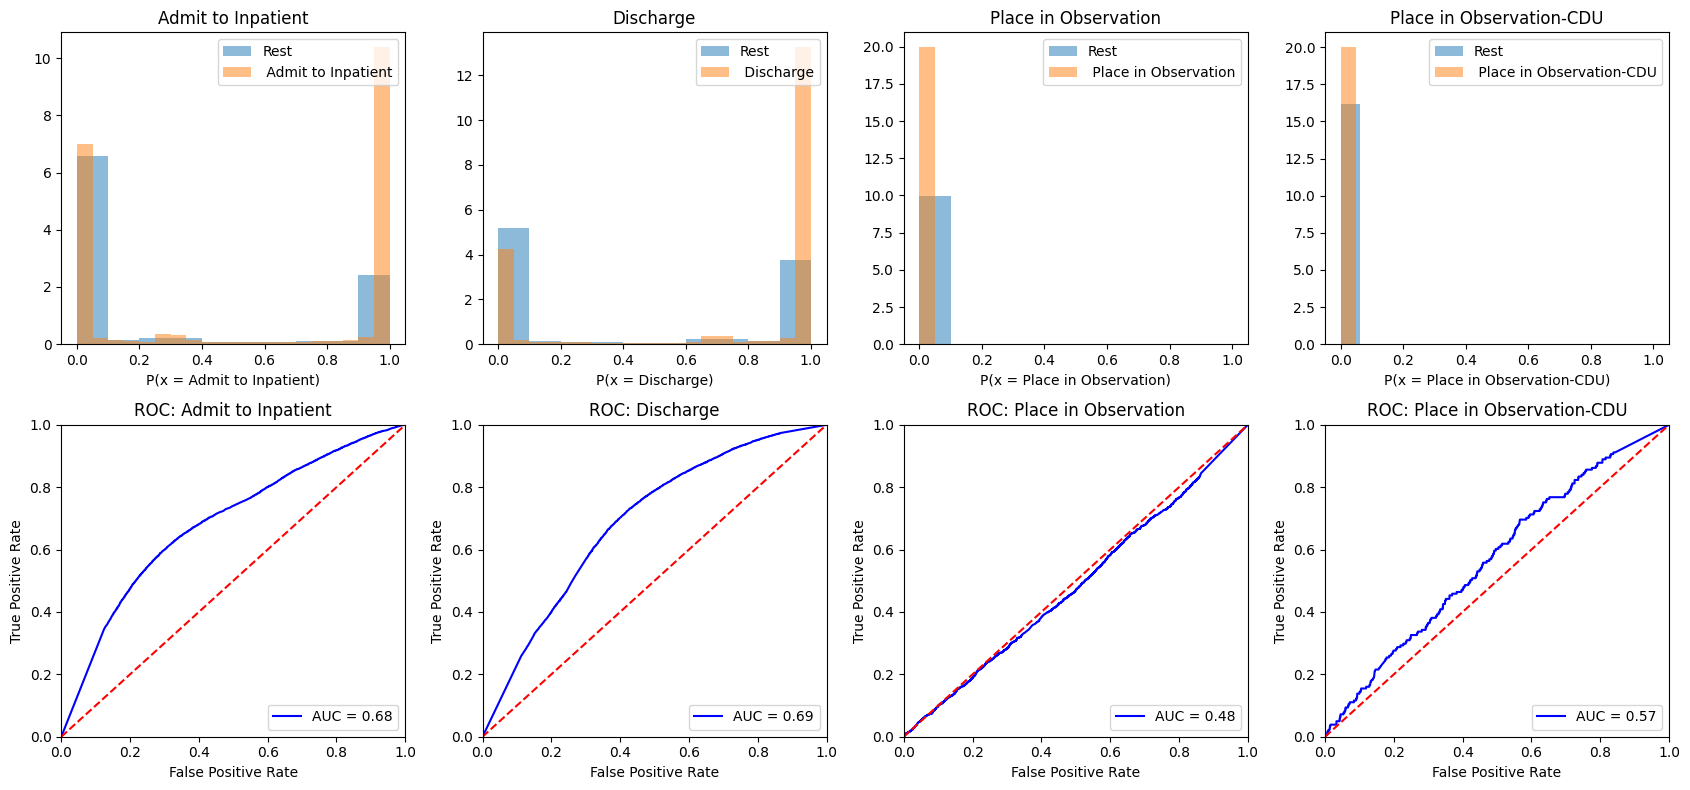

In [83]:
def plot_roc_curve(y_proba, y_test, labels, mlflow, split_type, columns):
    # Plots the Probability Distributions and the ROC Curves One vs Rest
    fig = plt.figure(figsize = (17, 8))
    bins = [i/20 for i in range(20)] + [1]
    roc_auc_ovr = {}
    for i in range(len(labels)):
        # Gets the class
        c = labels[i]
        column = columns[i]

        # Prepares an auxiliar dataframe to help with the plots
        df_aux = pd.DataFrame()
        df_aux['class'] = [1 if y == c else 0 for y in y_test]
        df_aux['prob'] = y_proba[:, i]
        df_aux = df_aux.reset_index(drop = True)

        # Plots the probability distribution for the class and the rest
        fig_upper = plt.subplot(2, 4, i+1)
        x = df_aux[df_aux['class'] ==0]
        plt.hist(x['prob'], density=True, alpha = 0.5, label='Rest')
        y = df_aux[df_aux['class'] ==1]
        plt.hist(y['prob'], density=True, alpha = 0.5, label=f" {column}", bins = bins)
        plt.title(column)
        plt.legend(loc='upper right')
        plt.xlabel(f"P(x = {column})")

        # Calculates the ROC Coordinates and plots the ROC Curves
        fpr, tpr, thresholds = sk.metrics.roc_curve(df_aux['class'], df_aux['prob'], pos_label=1)
        mauc = sk.metrics.auc(fpr, tpr)
        fig_bottom = plt.subplot(2, 4, i+5)
        plt.title( f"ROC: {column}")
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % mauc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        #plt.show()
#         mlflow.log_metric("auc_" + split_type + "_"+  c, mauc) 

    plt.tight_layout()
#     mlflow.log_figure(fig, "Hist_and_ROC_" + c+ "_"+ split_type + ".png") 
    
    
def evaluate(y_test, y_pred, mlflow, split_type, columns):
    """
    Evaluation function. For each of the text in evaluation data, it reads the score from
    the predictions made. And based on this, it calculates the values of
    True positive, True negative, False positive, and False negative.

    :param y_test: true labels
    :param y_pred: predicted labels
    :param labels: list of possible labels
    :return: evaluation metrics for classification like, precision, recall, and f_score
    """
     
    b = np.zeros_like(y_pred)
    b[np.arange(len(y_pred)), y_pred.argmax(1)] = 1
    y_proba = y_pred

    y_pred = pd.DataFrame(b, columns = list(columns))
    y_pred = y_pred.idxmax(axis=1)
    y_test = y_test.idxmax(axis=1)

    labels = list(y_test.unique())
    labels = sorted(labels)
#     labels = sorted(columns)
    
#     print(labels)
#     print(b)
#     print(y_proba)
#     print(y_pred)
#     print(y_test)
    plot_roc_curve(y_proba, y_test, labels, mlflow, split_type, sorted(columns))
    
evaluate(pd.DataFrame(val_data.y.cpu().numpy()), outputs.detach().numpy(), None, None, label_enc.categories_[0])

In [61]:
label_enc.categories_[0]

array(['Admit to Inpatient', 'Discharge', 'Place in Observation',
       'Place in Observation-CDU'], dtype=object)

In [46]:
m = torch.max(outputs, dim=1)
m[0]
#fpr, tpr, thresholds = sk.metrics.roc_curve(y_true, m[0], pos_label=i)
#auc = sk.metrics.auc(fpr, tpr)

tensor([0.9896, 1.0000, 0.9983,  ..., 1.0000, 0.9983, 0.8221], device='cuda:0',
       grad_fn=<MaxBackward0>)